## Access Vessel NRS CTD Profiles Delayed QC (Parquet)
This Jupyter notebook demonstrates how to access and plot vessel_nrs_ctd_profiles_delayed_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/7b901002-b1dc-46c3-89f2-b4951cedca48).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/vessel_nrs_ctd_profiles_delayed_qc.ipynb).


In [1]:
dataset_name = "vessel_nrs_ctd_profiles_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 71.7 ms, sys: 19.9 ms, total: 91.6 ms
Wall time: 8.73 s


In [4]:
aodn_dataset.dataset.partitioning.schema

site_code: string
timestamp: int32
polygon: string

## List unique partition values

In [5]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_code')
print(list(unique_partition_value)[0:4])  # showing a subset only

['NRSESP', 'NRSROT', 'NRSNIN']
CPU times: user 7.22 ms, sys: 375 µs, total: 7.6 ms
Wall time: 5.65 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


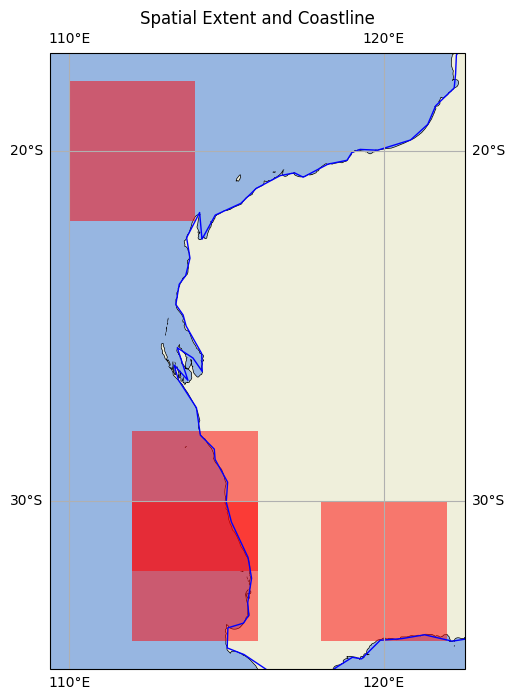

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
%%time
aodn_dataset.get_temporal_extent()

CPU times: user 183 ms, sys: 164 ms, total: 347 ms
Wall time: 983 ms


(Timestamp('2009-02-24 09:16:07.143999744'),
 Timestamp('2025-10-17 01:01:17.243995136'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-10-30 15:26:31,571 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/vessel_nrs_ctd_profiles_delayed_qc.parquet


{'DEPTH': {'type': 'float',
  'name': 'DEPTH',
  'standard_name': 'depth',
  'long_name': 'depth',
  'units': 'metres',
  'axis': 'Z',
  'positive': 'down',
  'reference_datum': 'sea surface',
  'valid_min': -5.0,
  'valid_max': 12000.0,
  'ancillary_variables': 'DEPTH_quality_control'},
 'DEPTH_quality_control': {'type': 'float',
  'long_name': 'quality flag for depth',
  'standard_name': 'depth status_flag',
  'valid_min': 0,
  'valid_max': 9,
  'quality_control_set': 1.0,
  'quality_control_conventions': 'IMOS standard set using the IODE flags',
  'flag_values': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'flag_meanings': 'No_QC_performed Good_data Probably_good_data Bad_data_that_are_potentially_correctable Bad_data Value_changed Not_used Not_used Not_used Missing_value',
  'quality_control_global_conventions': 'Argo reference table 2a (see http://www.cmar.csiro.au/argo/dmqc/user_doc/QC_flags.html), applied on data in position only (between global attributes time_deployment_start and time_de

# Data Query and Plot

## Create a TIME and scalar/number filter

This cell filters the dataset by time range and a scalar value (from a Parquet partition) using the `scalar_filter` argument.  
This leverages Parquet partitioning to apply efficient, server-side filtering, which significantly speeds up data loading.

In [9]:
%%time
df = aodn_dataset.get_data(date_start='2011-01-01', 
                           date_end='2023-01-01',
                           scalar_filter={'site_code': "NRSROT"})
df.info()

2025-10-30 15:26:39,845 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/vessel_nrs_ctd_profiles_delayed_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11368 entries, 0 to 11367
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DEPTH                      11368 non-null  float32       
 1   DEPTH_quality_control      364 non-null    float32       
 2   INSTANCE                   364 non-null    float64       
 3   TIME                       11368 non-null  datetime64[ns]
 4   TIME_quality_control       364 non-null    float32       
 5   DIRECTION                  11368 non-null  object        
 6   DIRECTION_quality_control  364 non-null    float32       
 7   LATITUDE                   11368 non-null  float64       
 8   LATITUDE_quality_control   364 non-null    float32       
 9   LONGITUDE                  11368 non-null  float64       
 10  LONGITUDE_quality_control  364 non-null    float32       
 11  PRES_REL                   11002 non-null  float32       
 12  PRES

In [10]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_7b901002-b1dc-46c3-89f2-b4951cedca48_vessel_nrs_ctd_profiles_delayed_qc_data-hash_6f48e042.csv.zip

## T-S Diagram

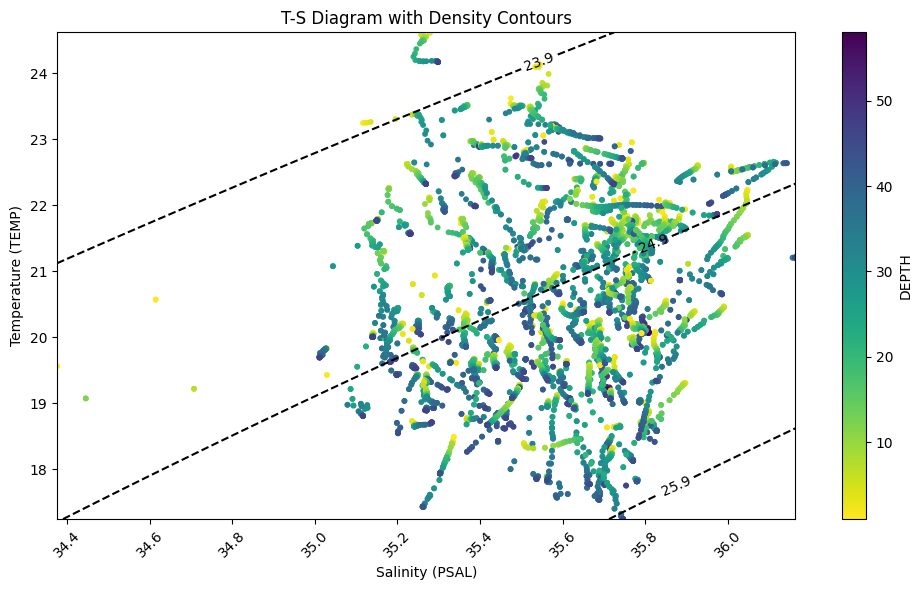

In [11]:
from DataQuery import plot_ts_diagram
plot_ts_diagram(df, temp_col='TEMP', psal_col='PSAL', z_col='DEPTH')

## Timeseries Profile

/tmp/ipykernel_1420625/131625765.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


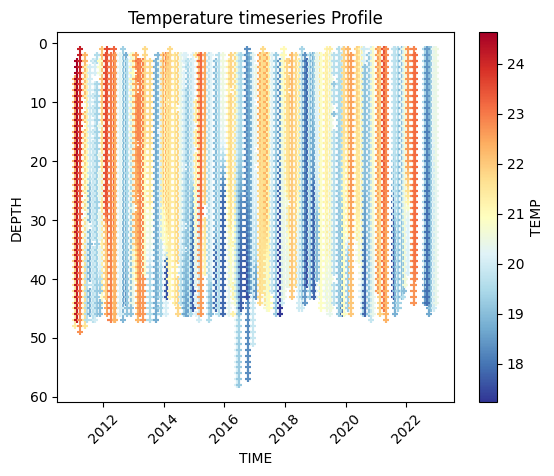

In [12]:
import matplotlib.pyplot as plt
ax = df.plot.scatter(x='TIME', y='DEPTH', c='TEMP', marker='+', linestyle="None", cmap='RdYlBu_r', title=f'Temperature timeseries Profile')

ax.invert_yaxis()

# Rotate x-axis labels at 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Show the plot
plt.show()


## Seasonal Temperature Profile

/tmp/ipykernel_1420625/2582188944.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.9,1])  # leave space for colourbar


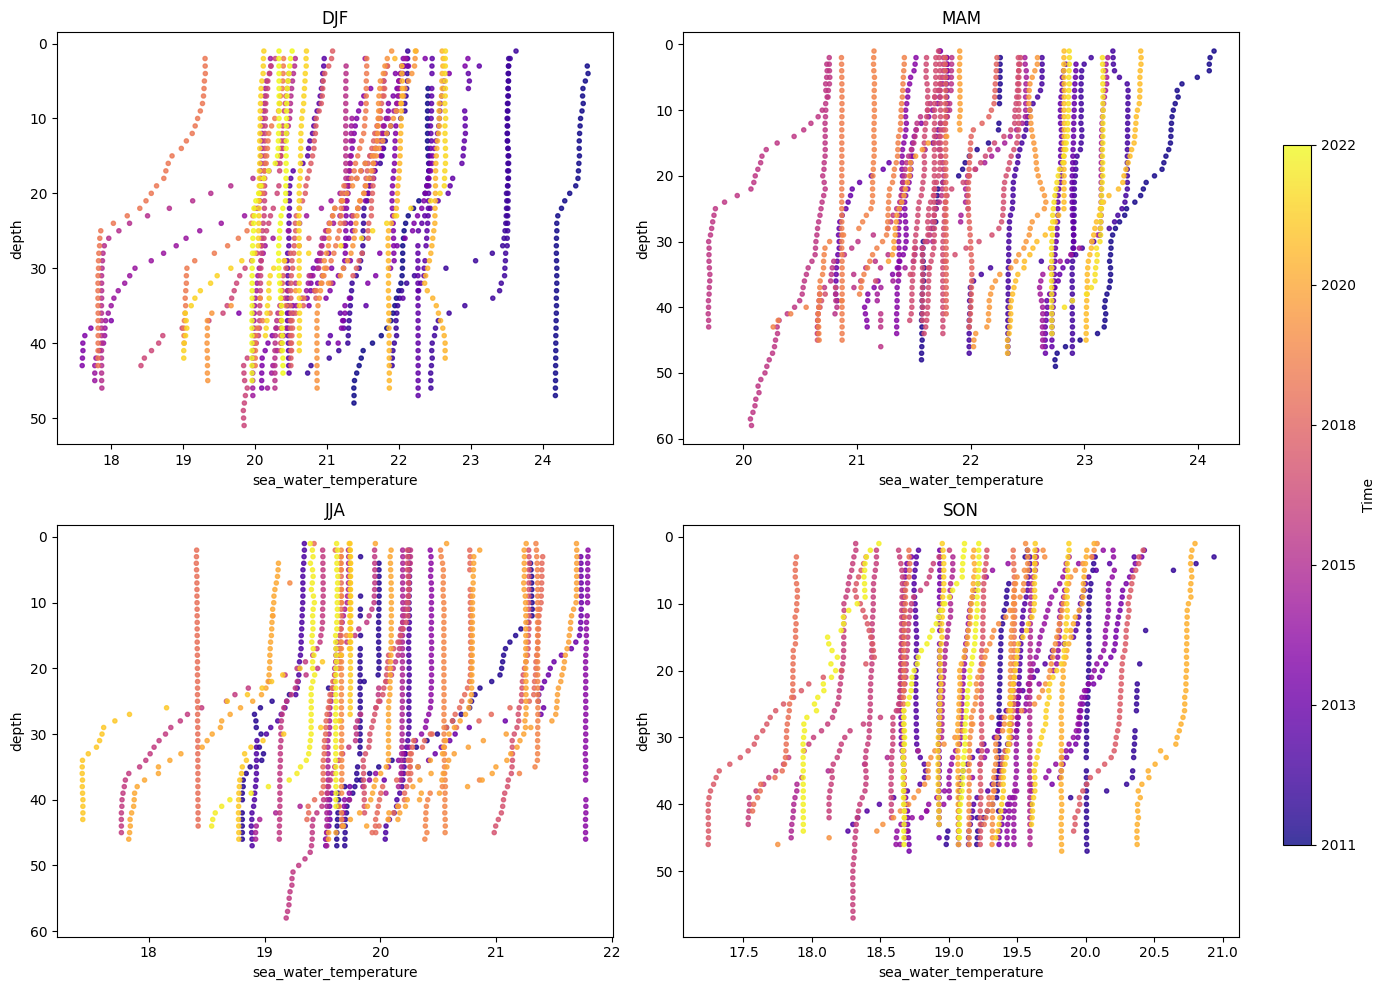

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

# --- Filter QC=1 data
df_good = df[df['TEMP_quality_control'] == 1].copy()
df_good['TIME'] = pd.to_datetime(df_good['TIME'])

# --- Season mapping
def get_season(month):
    if month in [12,1,2]: return 'DJF'
    elif month in [3,4,5]: return 'MAM'
    elif month in [6,7,8]: return 'JJA'
    else: return 'SON'

df_good['SEASON'] = df_good['TIME'].dt.month.map(get_season)

# --- Subplots (do NOT share y-axis)
seasons = ['DJF','MAM','JJA','SON']
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()

# --- Time to numeric across all data
times_num_all = mdates.date2num(df_good['TIME'])
norm_all = mcolors.Normalize(vmin=times_num_all.min(), vmax=times_num_all.max())
cmap = plt.get_cmap('plasma')

# --- Plot each season
for ax, season in zip(axes, seasons):
    df_season = df_good[df_good['SEASON']==season].sort_values('TIME')
    if df_season.empty:
        continue
    times_num = mdates.date2num(df_season['TIME'])
    sc = ax.scatter(df_season['TEMP'], df_season['DEPTH'], c=times_num, cmap=cmap,
                    norm=norm_all, marker='.', alpha=0.8)
    
    ax.invert_yaxis()  # invert depth axis reliably
    ax.set_title(season)
    ax.set_xlabel(metadata['TEMP']['standard_name'])
    ax.set_ylabel(metadata['DEPTH']['standard_name'])

# --- Dedicated colourbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax, label='Time')
n_ticks = 6
tick_locs = np.linspace(times_num_all.min(), times_num_all.max(), n_ticks)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([mdates.num2date(t).strftime('%Y') for t in tick_locs])

plt.tight_layout(rect=[0,0,0.9,1])  # leave space for colourbar
plt.show()
